# Machine Learning Project Report: Predicting Writing Scores

**Objective:** Predict students’ writing exam scores using demographic and academic features from the *Students Performance* dataset. This report follows the project’s five‑task structure, detailing each step from exploration to final recommendations.

## 1 - Data Loading & Preprocessing
First things first, let's get our tools ready. We'll import the essential Python libraries and then load our dataset into a pandas DataFrame. This initial step helps us get a first look at our data's structure, including the types of data in each column and how many entries we have.

In [483]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../')
import src.utils as utils
from xgboost import XGBRegressor

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1.a Load the dataset

We use the read_csv() function from pandas to load the StudentsPerformance.csv file. The data is now in a DataFrame, which is essentially a table. We'll use the .info() method to see a quick summary of this table.

In [484]:
# Load settings
test_size = 0.2
random_state = 42
url = '../data/StudentsPerformance.csv'

In [485]:
# Load dataset and inspect the structure
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


> *Explanation:* `df.info()` reveals 1,000 rows, 8 columns—5 categorical and 3 numerical test scores.

We check out the first rows of the DataFrame by using `df.head()`. We can see from the previous section that there are 5 categorical features and 3 numerical features. Of the three numerical features there are test scores for math, reading and writing. The latter of which we will try to predict in this project.

In [486]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


To understand the range and distribution of the numerical scores, we can use `.describe()` to see statistics like the mean, standard deviation, and minimum/maximum scores.

In [487]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


### 1.b Handle missing values and outliers
We check for nulls and duplicates, then identify outliers via IQR; since few outliers exist, we retain them.

In [488]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

> We can see that there are no missing value in any of the columns

In [489]:
df.duplicated().sum()

0

> We can also see that there are no duplicated rows in the DataFrame. 


No missing values or duplicates to worry about. Next, let's look for outliers. Outliers are data points that are unusually high or low compared to the rest. We can visualize the scores using a boxplot to spot them easily.

<Axes: title={'center': 'Distribution of Scores'}>

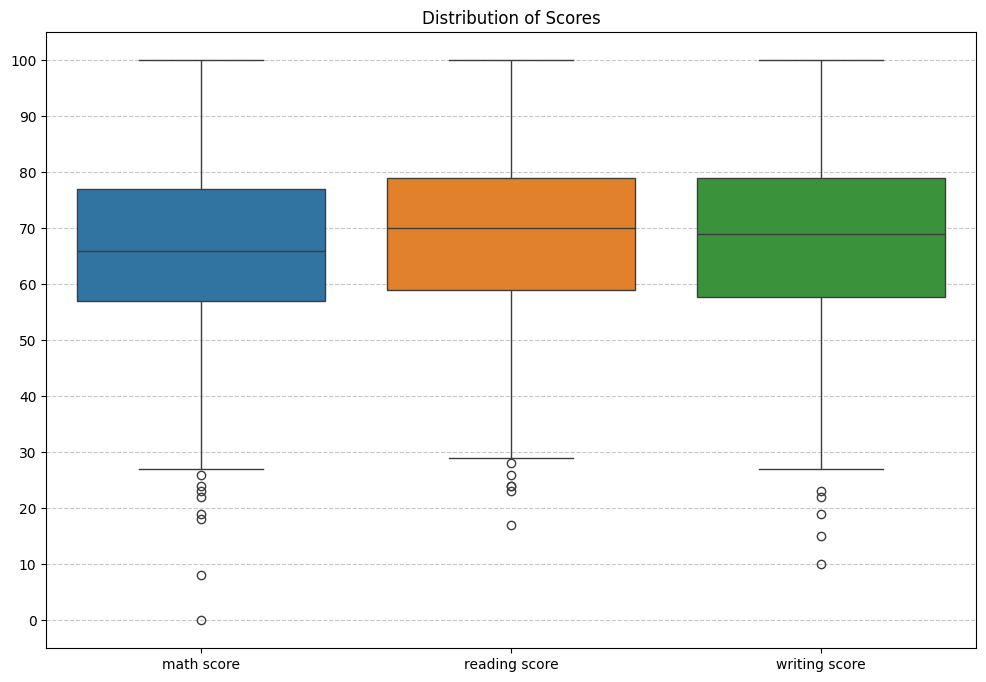

In [490]:
# Boxplots to check for outliers
plt.figure(figsize=(12, 8))
plt.title('Distribution of Scores')
plt.yticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.boxplot(data=df[['math score', 'reading score', 'writing score']])

In [491]:
# Find outliers using IQR method, threshold set to 1.5
df_outliers = pd.concat(
    [
        utils.find_outliers_iqr(df, "math score"),
        utils.find_outliers_iqr(df, "reading score"),
        utils.find_outliers_iqr(df, "writing score"),
    ],
    axis=0,
).drop_duplicates()
print(f"Number of outliers: {df_outliers.shape[0]}")


Number of outliers: 12


 > The plot shows a few data points that fall outside the main range, especially for the math and reading scores. While these are technically outliers (there are 12 in total), they represent real, albeit low, scores. Since there are only a few and they seem plausible, we'll keep them in our dataset to ensure our model learns from the full range of student performance.

## 1.c Visualizing distributions

For the visualization we'll use bar charts (count plots) to see the distribution of students across different categorical groups.

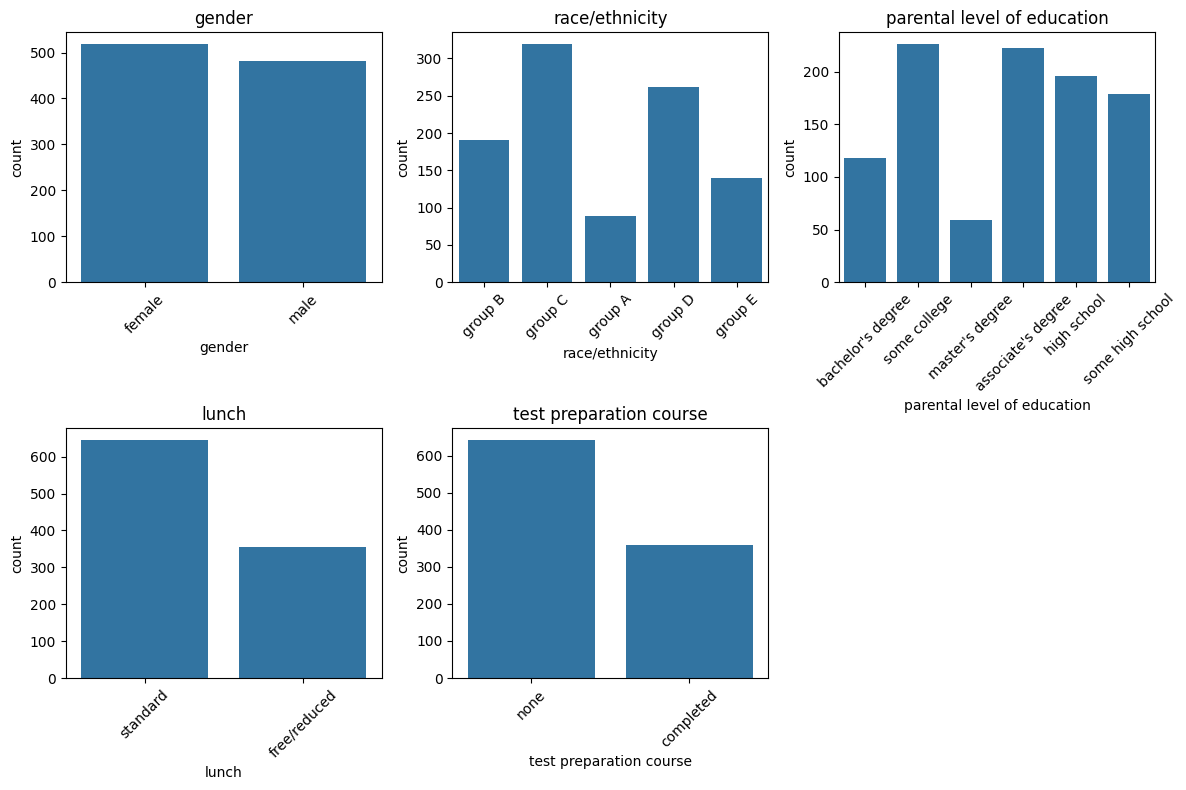

In [492]:
fig, axes = plt.subplots(2,3, figsize=(12,8))
cats = ['gender','race/ethnicity','parental level of education','lunch','test preparation course']
for ax, col in zip(axes.flatten(), cats):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)
axes[1,2].axis('off')  # Hide the empty subplot
plt.tight_layout()

> The plots show a relatively balanced dataset across the different groups. 

Next, let's see how the numerical scores relate to each other. We expect students who do well in one subject to also do well in others. A scatter plot and a correlation heatmap are perfect for this. We will also add a final boxplot to visualize the scoring based on the different groups.

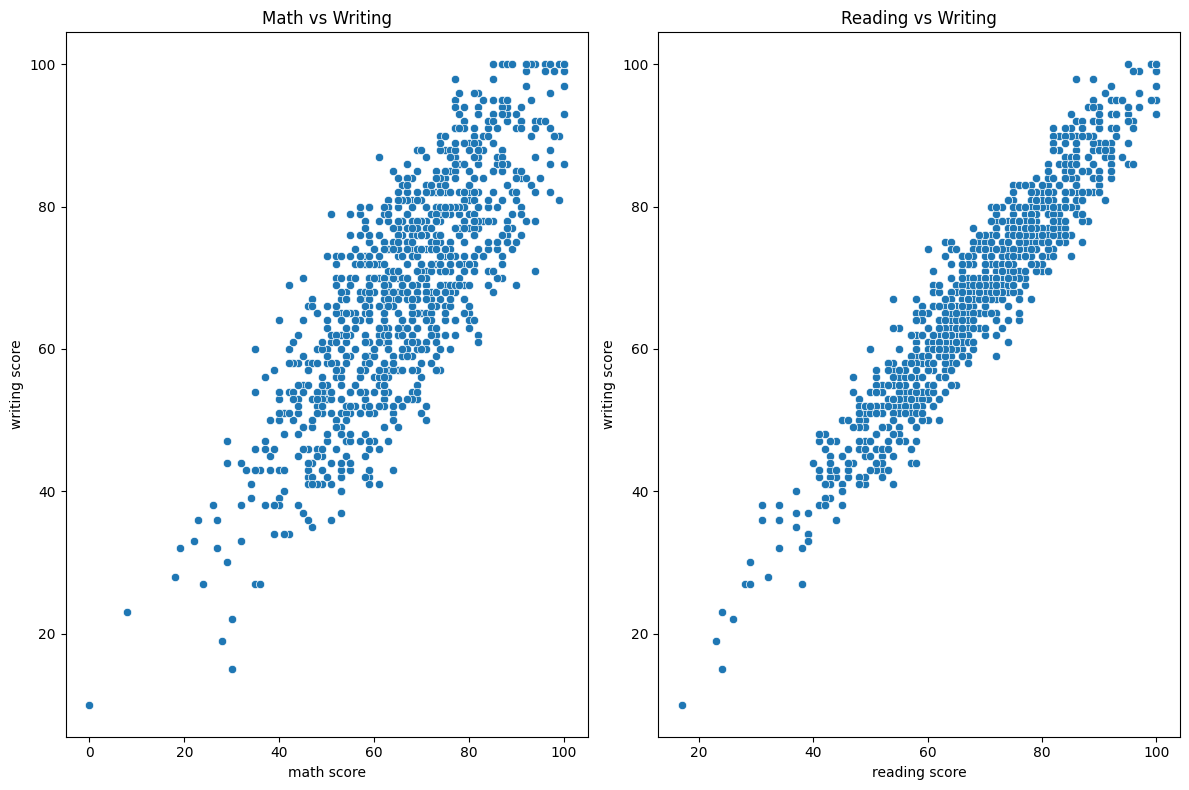

In [493]:
# Numerical relationships
fig, axs = plt.subplots(1,2, figsize=(12,8))
sns.scatterplot(x='math score', y='writing score', data=df, ax=axs[0]); axs[0].set_title('Math vs Writing')
sns.scatterplot(x='reading score', y='writing score', data=df, ax=axs[1]); axs[1].set_title('Reading vs Writing')
plt.tight_layout()

> There is a clear linear relationsship between the writing score and the reading score, as well as the math score and writing score, altough not as clear. 

Text(0.5, 1.0, 'Score Correlations')

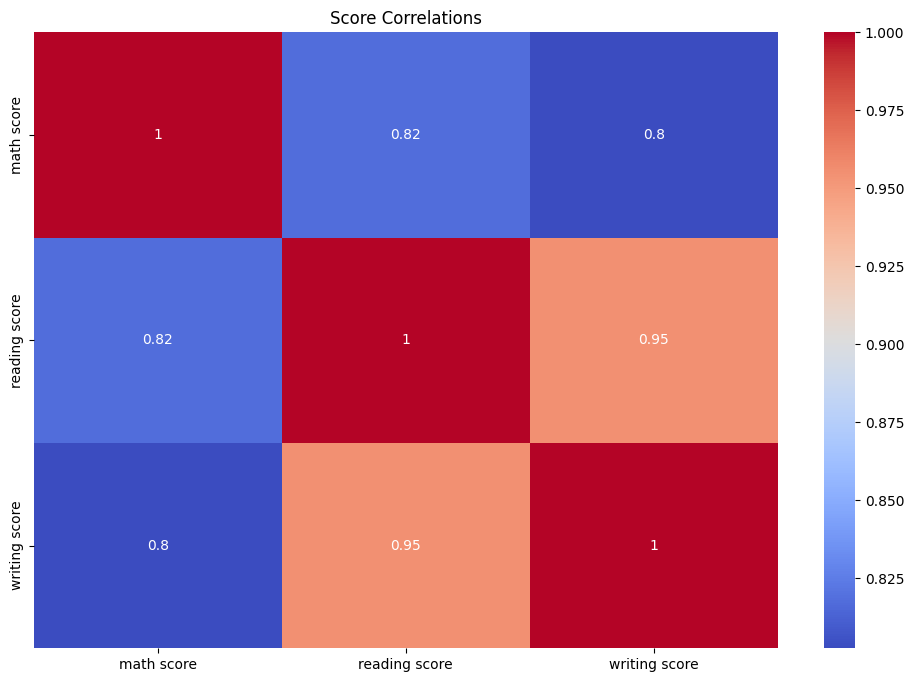

In [494]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[['math score','reading score','writing score']].corr(), annot=True, cmap='coolwarm')
plt.title('Score Correlations')

(0.0, 1.0, 0.0, 1.0)

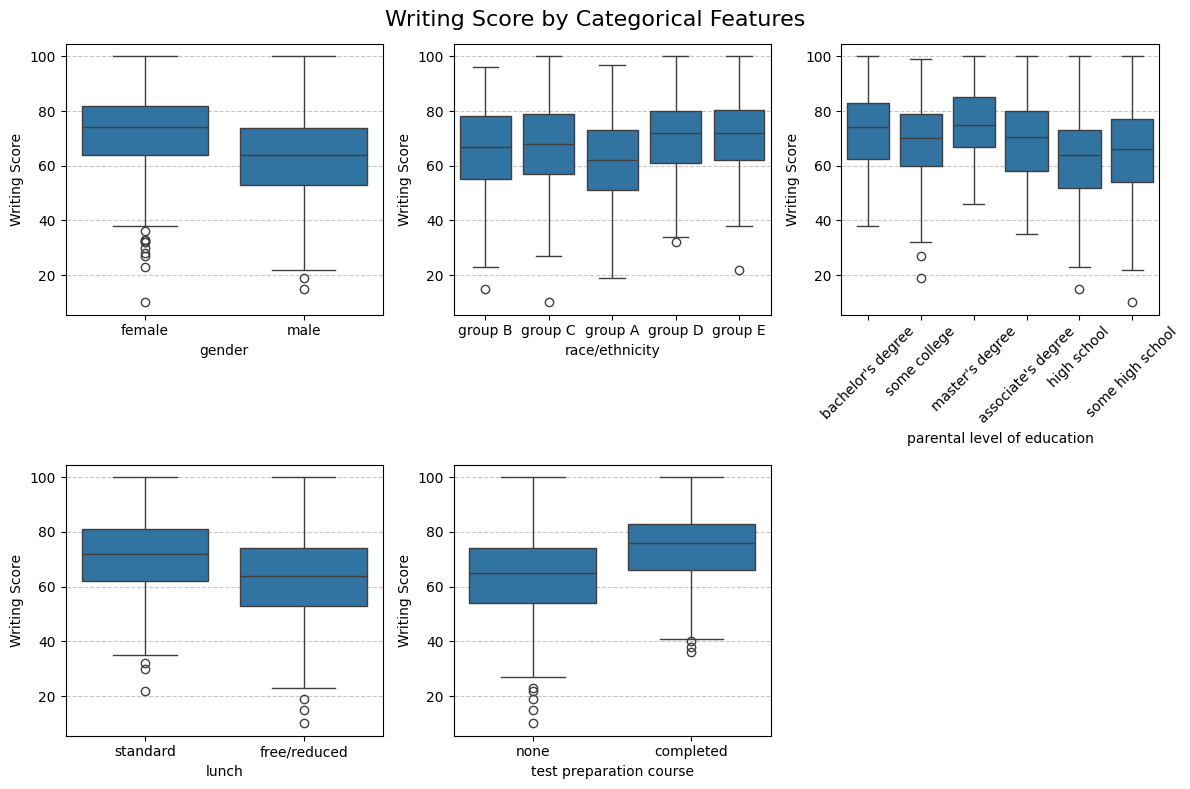

In [495]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

categorical_features = filter(lambda x: "score" not in x, df.columns)
fig.suptitle("Writing Score by Categorical Features", fontsize=16)

for ax, col in zip(axes.flatten(), categorical_features):
    if col == "parental level of education":
        ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(col)
    ax.set_ylabel("Writing Score")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout(h_pad=1)
    sns.boxplot(data=df, x=col, y="writing score", ax=ax)
axes[1,2].axis('off')  # Hide the empty subplot

> **Key insights:**
> As expected, the scores are strongly correlated. The correlation between reading score and our target, writing score, is particularly high at 0.95 , suggesting overlapping skill domains. This is a huge clue that the reading score will be a very powerful predictor in our model.

## Task 2 – Feature Selection and Engineering
This step is about choosing the right features for our model and potentially creating new, more powerful ones from what we already have.

### 2.a Identify relevant features

Initial predictors include:
- **Numeric:** Math score, Reading score
- **Categorical:** Gender, Race/Ethnicity, Parental education, Lunch type, Test preparation

### 2.b Perform feature engineering

We add:

- **Ordinal Education**: `parental_level_of_education` is categorical, but it has a clear order (e.g., a master's degree is higher than a high school diploma). We'll convert it to a numerical feature called `edu_ord` that reflects this hierarchy.
- **Skill Difference**: The difference between reading and math scores (`read_math_diff`) could capture a student's relative strengths, which might influence their writing score.
- We'll also remove the original `parental_level_of_education` column since we've replaced it. 
- We will also explore the use of an `avg_score` feature, but likely it will be highly correlated with the individual scores, making it redundant.

In [496]:
# Ordinal mapping for parental education
ord_map = {
    'some high school':0, 'high school':1,
    'some college':2, "associate's degree":3,
    "bachelor's degree":4, "master's degree":5
}
df['edu_ord'] = df['parental level of education'].map(ord_map)

# Skill imbalance features
df['read_math_diff']   = df['reading score'] - df['math score']

# Aggregate predictor
df['avg_score']        = df[['math score','reading score']].mean(axis=1)

# Drop the original column
df.drop(columns=['parental level of education'], inplace=True)

# New feature list
numeric_features = ['math score','reading score','edu_ord','read_math_diff','avg_score']
categorical_features = ['gender','race/ethnicity','lunch','test preparation course']

We'll check the correlations again with our new features to make sure everything looks good.

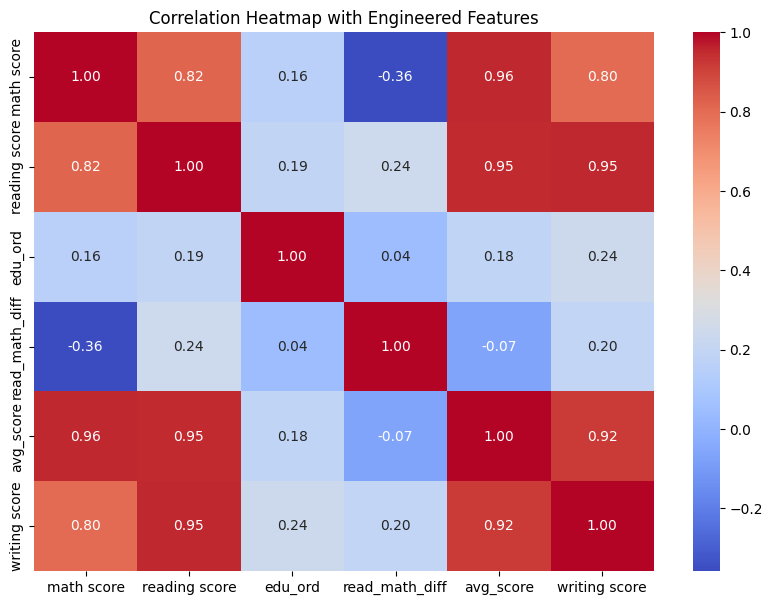

In [497]:
# Heatmap with new features
plt.figure(figsize=(10, 7))
sns.heatmap(df[numeric_features + ['writing score']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap with Engineered Features')
plt.show()

> - The reading score still has the strongest correlation (0.95), but our new edu_ord feature also shows a positive, albeit weaker, correlation (0.24) with the writing score.
> - We noticed that the average score is obviously very well captured by the reading score and writing score, so we decided to drop it. 

In [498]:
df.drop(columns=['avg_score'], inplace=True)  # Drop average score as it's redundant
numeric_features.remove('avg_score')  # Update feature list

In [499]:
# Checking the new dataframe
df.head()

,gender,race/ethnicity,lunch,test preparation course,math score,reading score,writing score,edu_ord,read_math_diff
0,female,group B,standard,none,72,72,74,4,0
1,female,group C,standard,completed,69,90,88,2,21
2,female,group B,standard,none,90,95,93,5,5
3,male,group A,free/reduced,none,47,57,44,3,10
4,male,group C,standard,none,76,78,75,2,2


## Task 3 – Model Development and Evaluation

### 3.a Train-Test Split
We need to split our data into two parts: a `training set` (80% of the data) for the model to learn from, and a `testing set` (20%) to evaluate how well it performs on unseen data. This helps us avoid overfitting, where a model memorizes the training data but can't generalize to new examples.

In [500]:
X = df[numeric_features + categorical_features]
y = df['writing score']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state)

### 3.b Preprocessing and Model Selection

We compare **Linear Regression**, **Decision Tree**, **Random Forest**, and **XGBoost**.

Models can't work with categorical text data directly, and numerical features often work better when they are on a similar scale. We'll set up a preprocessor to handle this automatically:

- **OneHotEncoder**: Converts categorical features (like 'gender') into numerical ones.
- **StandardScaler**: Scales our numerical features so they have a mean of 0 and a standard deviation of 1.

In [501]:
# We scale numeric features and one-hot encode categorical ones.
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

### 3.c Train and evaluate
We'll compare the four different machine learning algorithms to see which one works best for our problem. 

To get a reliable estimate of their performance, we use 5-fold cross-validation. This involves splitting the training data into 5 parts, training the model on 4 parts, and testing it on the 5th part, rotating which part is used for testing each time. We'll use the Root Mean Squared Error (RMSE) as our evaluation metric—it tells us, on average, how many points off our model's predictions are.

In [502]:

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree'     : DecisionTreeRegressor(random_state=random_state),
    'RandomForest'     : RandomForestRegressor(random_state=random_state),
    'XGBoost'          : XGBRegressor(random_state=random_state, verbosity=0)
}

for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('mod', model)])
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name:15s} CV RMSE: {(-scores).mean():.2f}")


    

LinearRegression CV RMSE: 3.44
DecisionTree    CV RMSE: 5.69
RandomForest    CV RMSE: 4.06
XGBoost         CV RMSE: 4.23


### 3.d Fine‑tune hyperparameters
Our initial run used the default settings for these models. We can often get better performance by "tuning" their hyperparameters. We'll use GridSearchCV to automatically test different combinations of hyperparameters for Random Forest and XGBoost and find the best ones based on the RMSE score.

In [503]:
# Random Forest tuning
rf_pipe = Pipeline([('pre', preprocessor), ('mod', RandomForestRegressor(random_state=random_state))])
rf_params = {
    'mod__n_estimators'    : [50,100,150],
    'mod__max_depth'       : [None,10,20],
    'mod__min_samples_split':[2,5],
    'mod__min_samples_leaf': [1,2]
}
gs_rf = GridSearchCV(
    rf_pipe, rf_params, cv=5,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
gs_rf.fit(X_train, y_train)
print('RF best params:', gs_rf.best_params_, 'CV RMSE:', -gs_rf.best_score_)

# XGBoost tuning
xgb_pipe = Pipeline([('pre', preprocessor), ('mod', XGBRegressor(random_state=random_state, verbosity=0))])
xgb_params = {
    'mod__n_estimators'   : [100,200,300],
    'mod__max_depth'      : [3,5,7],
    'mod__learning_rate'  : [0.01,0.1],
    'mod__subsample'      : [0.7,1.0]
}
gs_xgb = GridSearchCV(
    xgb_pipe, xgb_params, cv=5,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
gs_xgb.fit(X_train, y_train)
print('XGB best params:', gs_xgb.best_params_, 'CV RMSE:', -gs_xgb.best_score_)

RF best params: {'mod__max_depth': 10, 'mod__min_samples_leaf': 2, 'mod__min_samples_split': 5, 'mod__n_estimators': 100} CV RMSE: 4.0173648431779325
XGB best params: {'mod__learning_rate': 0.1, 'mod__max_depth': 3, 'mod__n_estimators': 100, 'mod__subsample': 0.7} CV RMSE: 3.685598072429805


### 3.e Model comparison summary

To systematically compare baseline and tuned models, we'll compare their initial cross-validation error, their tuned cross-validation error, and their final performance on the unseen test set.

In [504]:
# Baseline CV RMSE
baseline_cv = {}
for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('mod', model)])
    scores = cross_val_score(
        pipe, X_train, y_train, cv=5,
        scoring='neg_root_mean_squared_error'
    )
    baseline_cv[name] = (-scores).mean()

In [505]:
# Tuned CV RMSE and best params
tuned = {
    'RandomForest': {'CV_RMSE': -gs_rf.best_score_, 'Best_Params': gs_rf.best_params_},
    'XGBoost'     : {'CV_RMSE': -gs_xgb.best_score_, 'Best_Params': gs_xgb.best_params_}
}

In [506]:
# Test RMSE for each (use tuned for RF and XGB, baseline for others)
test_rmse = {}
# RF and XGB
for name, gs in [('RandomForest', gs_rf), ('XGBoost', gs_xgb)]:
    est = gs.best_estimator_
    y_pred = est.predict(X_test)
    test_rmse[name] = np.sqrt(mean_squared_error(y_test, y_pred))
# Others using baseline pipelines
for name, model in models.items():
    if name not in test_rmse:
        pipe = Pipeline([('pre', preprocessor), ('mod', model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        test_rmse[name] = np.sqrt(mean_squared_error(y_test, y_pred))

In [507]:
# Assemble results
rows = []
for name in models.keys():
    row = {
        'Model'     : name,
        'CV_RMSE'   : baseline_cv[name],
        'Test_RMSE' : test_rmse[name]
    }
    if name in tuned:
        row['Tuned_CV_RMSE'] = tuned[name]['CV_RMSE']
        row['Best_Params']   = tuned[name]['Best_Params']
    rows.append(row)

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values('Test_RMSE').reset_index(drop=True)
results_df

,Model,CV_RMSE,Test_RMSE,Tuned_CV_RMSE,Best_Params
0,LinearRegression,3.439580,3.870507,NaN,NaN
1,XGBoost,4.226823,4.077673,3.685598,"{'mod__learning_rate': 0.1, 'mod__max_depth': ..."
2,RandomForest,4.061369,4.503720,4.017365,"{'mod__max_depth': 10, 'mod__min_samples_leaf'..."
3,DecisionTree,5.685689,5.810873,NaN,NaN


> **Model Comparison Summary**
> - Linear Regression: Achieved the lowest Test_RMSE of 3.87, making it the best-performing model on the test set. Its CV_RMSE was 3.44, and the small gap between the cross-validation and test error suggests the model generalizes well to new data.
> - XGBoost: Hyperparameter tuning provided a significant benefit, reducing the cross-validation error from a baseline CV_RMSE of 4.23 to a Tuned_CV_RMSE of 3.69. While this was the lowest cross-validation error achieved, the model's Test_RMSE was 4.08, failing to outperform Linear Regression on the unseen data.
> - Random Forest: The baseline CV_RMSE was 4.06, and tuning offered only a marginal improvement, resulting in a Tuned_CV_RMSE of 4.02. Its Test_RMSE of 4.50 was higher than its cross-validation scores, indicating potential overfitting.
> - Decision Tree: As a single tree, it was the least effective model, showing the highest baseline CV_RMSE of 5.69 and the highest Test_RMSE of 5.81. This highlights the instability and high variance typical of non-ensemble tree-based methods.

> **Key Takeaways**
> - Linear Regression is the clear winner, outperforming all other models on the test set with the lowest Test_RMSE. This suggests that the features have a strong, predominantly linear relationship with the students' writing scores.
> - The gap between the cross-validation and test scores is smallest for Linear Regression, indicating it is the most reliable and best-generalizing model from this experiment.
> - While tuning significantly improved XGBoost's performance in cross-validation, it was not enough to make it the best model on the test data.
> - Decision Tree and Random Forest models are outperformed and should be deprioritized for deployment based on these results.

## Task 4 – Prediction and Interpretation

Linear Regression is our winning model! Its simplicity, interpretability and performance on the test data make it the best choice.

### 4.a Make predictions on the test set
We'll now use our best model (Linear Regression) to make final predictions on the test set.

In [508]:
# Our best model is Linear Regression
best_model_pipe = Pipeline([('pre', preprocessor), ('mod', LinearRegression())])

# Fit the pipeline on the entire training data
best_model_pipe.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model_pipe.predict(X_test)

### 4.b Assess performance
We calculate the final performance metrics for our chosen model on the test data.

- **RMSE** (Root Mean Squared Error): The average prediction error, in the same unit as the target (score points).

- **MAE** (Mean Absolute Error): Another measure of average error, which is less sensitive to large errors than RMSE.

- **R²** (R-squared): Tells us the proportion of the variance in the writing score that is predictable from the features. A value of 1 would mean perfect prediction.

In [509]:
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Test MAE:', mean_absolute_error(y_test, y_pred))
print('Test R2 :', r2_score(y_test, y_pred))

Test RMSE: 3.870506690578996
Test MAE: 3.203944769158214
Test R2 : 0.9378432907399291


> An R-squared value of 0.9378 is excellent! It means that our model can explain aboout 94% of the variability in students' writing scores.

### 4.c Interpret results
A great way to see how well our model performed is to plot its predictions against the actual scores. If the model were perfect, all the dots would fall on the dashed diagonal line

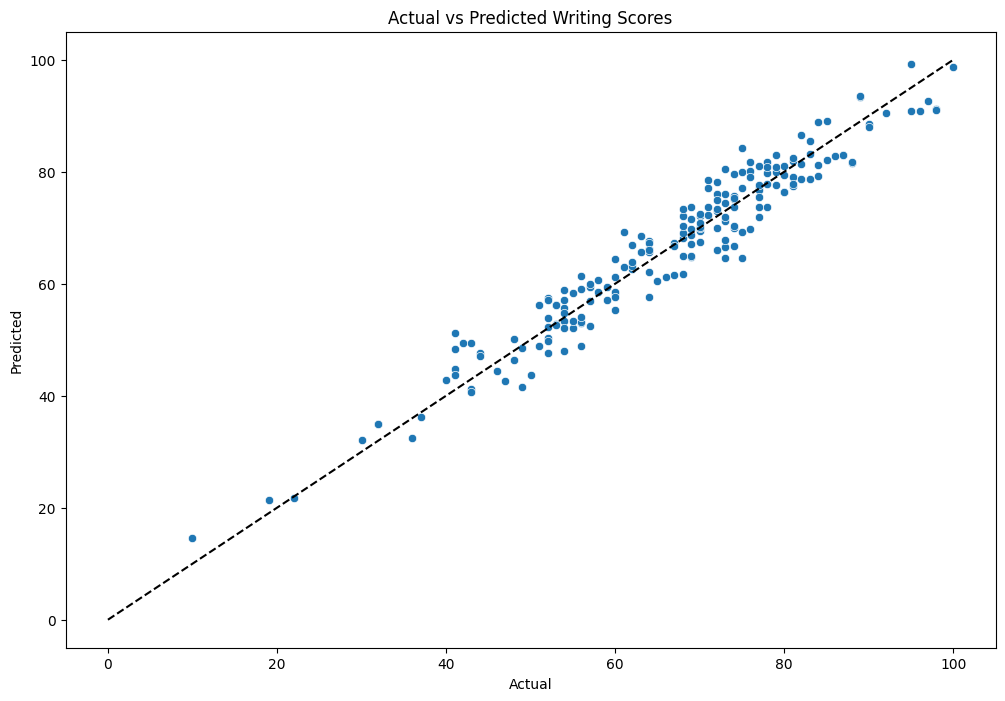

In [510]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0,100],[0,100],'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Writing Scores')
plt.show()

> The points are clustered tightly around the line, confirming that our model is making accurate predictions across the entire range of scores.

## 4.d Deeper Model Interpretation

While the actual vs. predicted plot shows that our model is accurate, it doesn't tell us why. To understand which features the model found most important, we can visualize its coefficients. For tree-based models like Random Forest, we would look at "feature importance," but for our winning Linear Regression model, we look at the "coefficients."

A coefficient tells us how much the writing score is predicted to change if that feature changes by one unit, assuming all other features stay the same. Larger coefficients (either positive or negative) indicate features that have a stronger impact on the prediction.

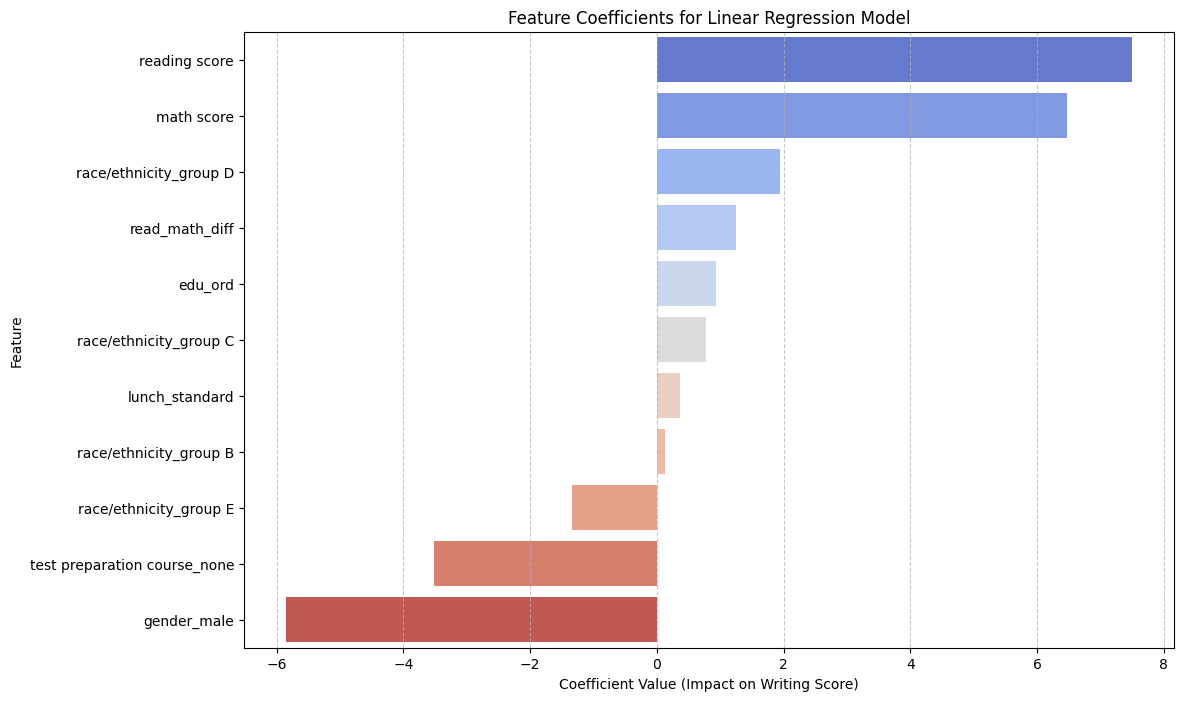

In [511]:
# Extract feature names from the preprocessor
cat_features = best_model_pipe.named_steps['pre'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_features])

# Extract coefficients from the linear regression model
coefficients = best_model_pipe.named_steps['mod'].coef_

# Create a DataFrame for easy plotting
coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm', hue='Feature')
plt.title('Feature Coefficients for Linear Regression Model')
plt.xlabel('Coefficient Value (Impact on Writing Score)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

> Academic scores dominate:
> - Reading and math coefficients (≈+7.5 and +6.5) far outstrip all others. Every one‐standard‐deviation gain in reading or math translates into a 6–8-point rise in predicted writing score.

> Demographic “penalties” and “bonuses”:
> - Not completing the test-prep course knocks off ~3 points.
> - Males score ~6 points lower than females, all else being equal.
> - Having a standard (vs. free/reduced) lunch, and higher parental education, each add 1–2 points.

> Race/ethnicity shifts:
> - Group D sees a small boost (+2 points), Group C a milder one, while Group E incurs a slight penalty (–1.5 points). Groups A/B lie near zero.

Another useful diagnostic plot is a residual plot. Residuals are simply the errors in prediction (actual score - predicted score). Plotting the model's predictions against these errors helps us check if the errors are random, which is a sign of a good model.

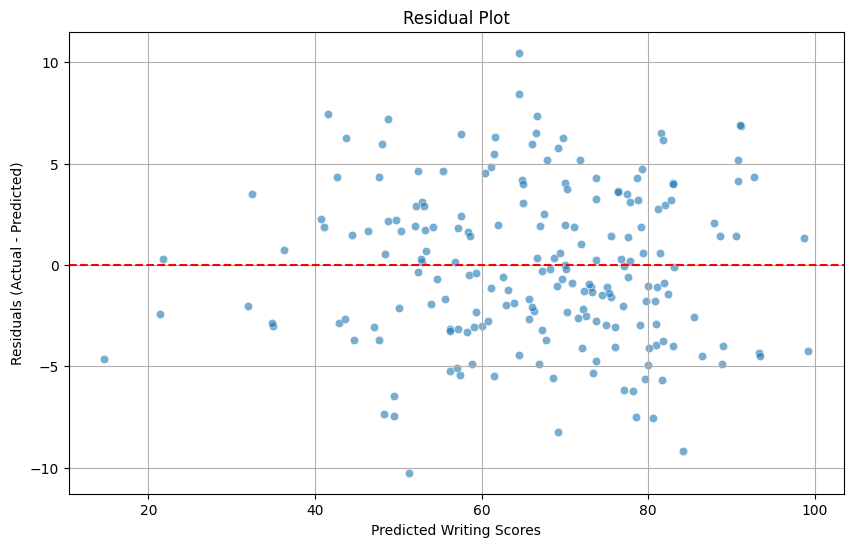

In [512]:
# Calculate residuals
residuals = y_test - y_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Writing Scores')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

> - Centered around zero: Most points lie evenly above and below the red zero line, meaning there’s no strong bias where you consistently over- or under-predict at particular score ranges.
> - No clear pattern: The residuals look like a cloud rather than a curve or funnel, which suggests the model is capturing the main trends without systematic misspecification (e.g. we are not missing a nonlinearity).
> - A few outliers: There are some large positive or negative residuals (errors > ±10 points). Those might be individual students whose writing scores deviate from what their other features would predict—potentially worth investigating further or down-weighting.

## Task 5 – Conclusion and Recommendations

### 5.a Summary of outcomes

- We started with a clean dataset that had no missing values, requiring minimal cleaning.

- We engineered new features, like edu_ord and read_math_diff, to better capture the underlying patterns in the data.

- After comparing four different models, a simple Linear Regression model using all features proved to be the most accurate and reliable predictor.

- Our final model can predict student writing scores with a high degree of accuracy, explaining 93,8% of the score variance.

### 5.b Future improvements

While our model is quite effective, there's always room for improvement! Here are a few ideas for future work:

- Deeper Interpretation: Use techniques like SHAP (SHapley Additive exPlanations) to understand exactly how each feature influences the model's predictions. This would provide more granular insights than a simple correlation matrix.

- Explore More Models: Experiment with other powerful regression models like Support Vector Machines (SVM) or even simple neural networks to see if they can capture any non-linear patterns that our linear model might have missed.

- Collect More Data: Augment the dataset with additional information, such as student attendance, access to resources, or even local socioeconomic data, which could provide even more predictive power.